In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics as stat

from scipy.signal import lfilter

In [36]:
class LRegression:
    def __init__(self, x, y, color, title, filename, xlabel, ylabel):
        self.x = x
        self.y = y
        self.x_mean = stat.mean(x)
        self.y_mean = stat.mean(y)

        self.color = color
        self.title = title
        self.filename = filename
        self.xlabel = xlabel
        self.ylabel = ylabel
    
    def get(self):
        #definicao do coeficiente angular (a):
        a_def = 0
        for i in range(len(self.x)):
            a_def += ((self.x[i]-self.x_mean) * (self.y[i]-self.y_mean))
        a_div = 0
        for i in range(len(self.x)):
            a_div += pow((self.x[i] - self.x_mean), 2)
        a = (a_def/a_div)
        b = self.y_mean - (self.x_mean * a) #definicao do coeficiente linear (b)
        
        #incerteza de Y
        incY = 0
        for i in range(len(self.x)):
            incY += pow((self.y[i] - (a * self.x[i] + b)), 2)
        
        incY *= (1/(len(self.x)-2))
        incY = pow(incY, 0.5)
    	
        #incerteza de a:
        incA = 0
        incA = pow(a_div, -1)
        incA = pow(incA, 0.5)
        incA *= incY
        
        #incerteza de b:
        incB = 0
        for i in range(len(self.x)):
            incB += (pow(self.x[i], 2))

        incB*= (1/len(self.x))
        incB = incB/a_div
        incB = pow(incB, 0.5)
        incB*= incY

        y=[]
        for i in range(len(self.x)):
            y.append(a*self.x[i]+b)
       
        
        plt.plot(self.x, self.y, 'k^', label='Dados coletados')
        plt.plot(self.x, y, self.color, label=f'Regressão linear (y = {a :.6f}x + {b :.6f})')
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.legend()
        plt.grid(True)
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.savefig(self.filename, dpi=100, edgecolor="#04253a")
        plt.show() #plot do grafico

        return a, b, incA, incB, incY

In [37]:
class Data():
    def __init__(self, filename):
        data = pd.read_csv(filename)
        d_time = data.drop(columns=['V'])
        d_V  = data.drop(columns=['T'])
        x = d_time.iloc[:, :].values
        y =  d_V.iloc[:, :].values

        self.x = np.array(x, dtype=float)
        self.x = self.x.squeeze()
        self.y = np.array(y, dtype=float)
        self.y = self.y.squeeze()

    def __len__(self):
        return len(self.x)
    
    def __getparams__(self):
        return self.x, self.y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    

data = Data("exp1-oscread.csv")
print(f"Data size: [{data.__len__()}]")


Data size: [2483]


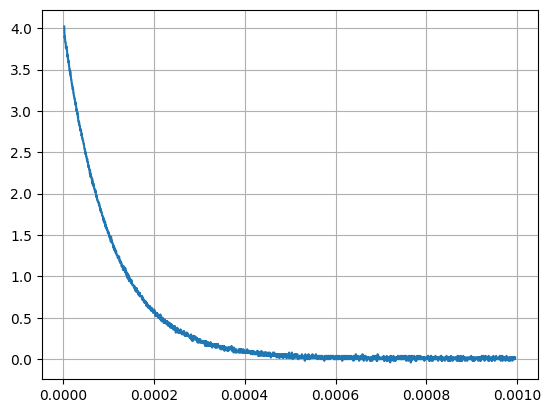

In [38]:
plt.plot(data.x, data.y)
plt.grid(True)
plt.savefig("Unfiltered.jpg", dpi=150, edgecolor="#04253a")
plt.show()

## Control

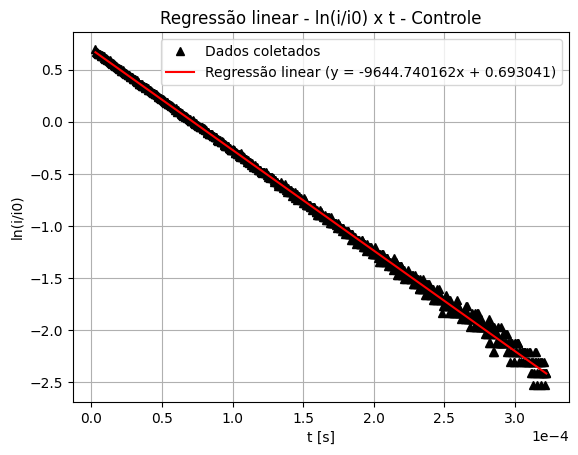

(-9644.740162260625,
 0.6930408111429208,
 13.445864123686288,
 0.0025144873193369333,
 0.03513117922448168)

In [39]:
t = data.x[:800]
VR = data.y[:800]
R = 1000

i = []
for e in range(len(VR)):
    i.append(VR[e]/R)

ii0 = []
for e in range(len(i)):
    ii0.append(i[e]/0.002)

lnii0 = []
for e in range(len(i)):
    lnii0.append(np.log(ii0[e]))
    
regression = LRegression(t, lnii0, 'r-', "Regressão linear - ln(i/i0) x t - Controle", "exp1-reg.jpg", "t [s]", "ln(i/i0)")
regression.get()

## Simple IIR Filter (Impulse Infinity Response)

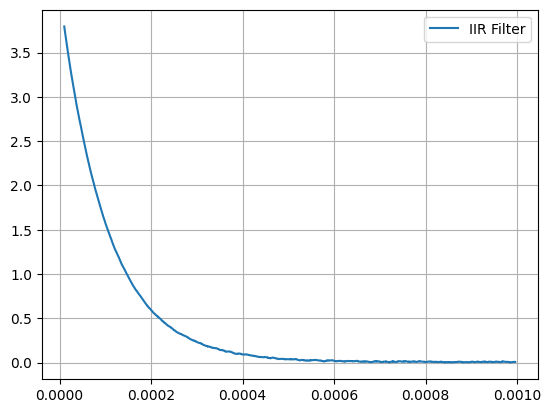

In [40]:
n = 20
start_value = n-1
b = [1.0/n]*n
a=1
yy = lfilter(b, a, data.y)
plt.plot(data.x[start_value:], yy[start_value:], label="IIR Filter")
plt.legend()
plt.grid(True)
plt.savefig("IIRFilter.jpg", dpi=150, edgecolor="#04253a")
plt.show()

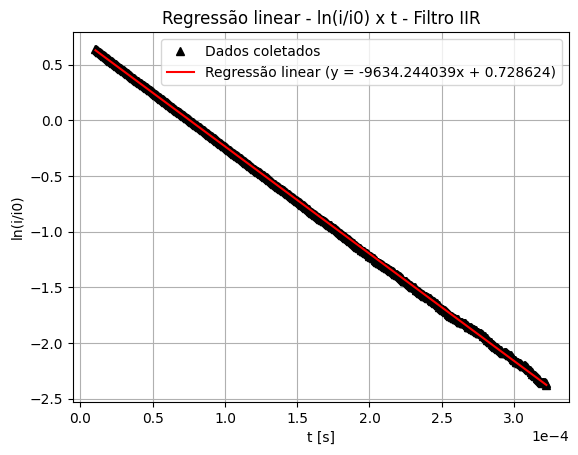

(-9634.244038892906,
 0.7286242718171698,
 4.03847637932496,
 0.0007643477773096468,
 0.010178015553289907)

In [41]:
t = data.x[start_value:800]
VR = yy[start_value:800]
R = 1000

i = []
for e in range(len(VR)):
    i.append(VR[e]/R)

ii0 = []
for e in range(len(i)):
    ii0.append(i[e]/0.002)

lnii0 = []
for e in range(len(i)):
    lnii0.append(np.log(ii0[e]))

regression = LRegression(t, lnii0, 'r-', "Regressão linear - ln(i/i0) x t - Filtro IIR", "exp1-reg.jpg", "t [s]", "ln(i/i0)")
regression.get()

## Kalman Filter

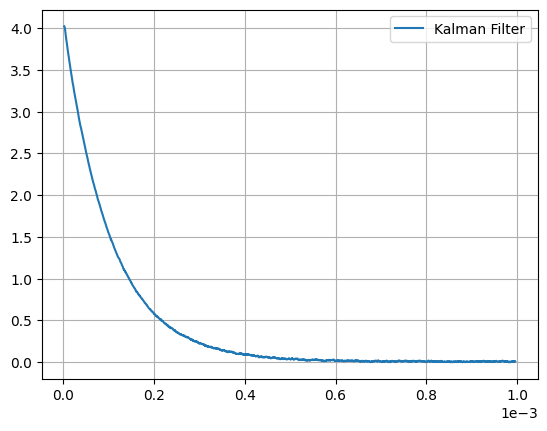

In [47]:
# KALMAN FILTERING
class KFilter():
    def __init__(self, iterations, z, process_variance, measurement_variance):
        self.iter = iterations
        self.z = z
        self.Q = process_variance
        self.R = measurement_variance
        self.sz = (iterations, )

    def filter(self):
        # allocate space for arrays
        Vhat=np.zeros(self.sz)      # a posteri estimate of x
        P=np.zeros(self.sz)         # a posteri error estimate
        Vhatminus=np.zeros(self.sz) # a priori estimate of x
        Pminus=np.zeros(self.sz)    # a priori error estimate
        K=np.zeros(self.sz)         # gain or blending factor

        # intial guesses
        Vhat[0] = self.z[0]
        P[0] = 0

        for k in range(1,self.iter):
            # time update
            Vhatminus[k] = Vhat[k-1]
            Pminus[k] = P[k-1]+self.Q

            # measurement update
            K[k] = Pminus[k]/( Pminus[k]+self.R )
            Vhat[k] = Vhatminus[k]+K[k]*(self.z[k]-Vhatminus[k])
            P[k] = (1-K[k])*Pminus[k]
                
        return Vhat

kfilter = KFilter(data.y.size, data.y, 3*1e-3, 0.1**1)
Vhat = kfilter.filter()

plt.plot(data.x, Vhat, label='Kalman Filter')
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.savefig("KalmanFilter.jpg", dpi=150, edgecolor="#04253a")
plt.show()


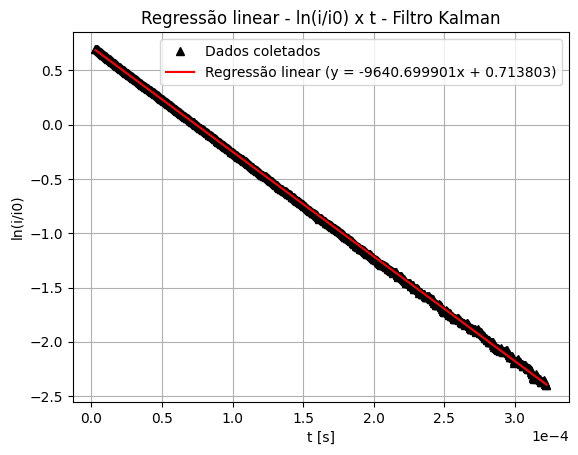

(-9640.6999010113,
 0.7138031421217539,
 4.539494943966781,
 0.0008489229377746544,
 0.011860733456631372)

In [49]:
t = data.x[:800]
VR = Vhat[:800]

R = 1000

i = []
for e in range(len(VR)):
    i.append(VR[e]/R)

ii0 = []
for e in range(len(i)):
    ii0.append(i[e]/0.002)

lnii0 = []
for e in range(len(i)):
    lnii0.append(np.log(ii0[e]))

regression = LRegression(t, lnii0, 'r-', "Regressão linear - ln(i/i0) x t - Filtro Kalman", "exp1-reg2.jpg", "t [s]", "ln(i/i0)")
regression.get()